# 作業用ノートブック
## モデル保存

In [1]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.nn import Linear
from torchsummary import summary
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)

for name, param in model.named_parameters():  
    if "classifier" in name:
        continue
    param.requires_grad = False
model.classifier[-1] = Linear(1280, 2, bias=True)

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

In [21]:
model.load_state_dict(torch.load("../resources/best_model_exp2_143.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

## モデルのTorchscript形式へのトランスパイルと保存

In [22]:
model_torchscript = torch.jit.script(model)
torch.jit.save(model_torchscript, "../resources/model_torchscript_exp2.pth")

## データセットの読み込みとHDF5への格納

In [2]:
# ImageNetで訓練済の重みを使用する際は、訓練時に下記の正規化処理が入っているため、再現
# また入力サイズは224*224に固定する。
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
test_transform = v2.Compose([v2.Resize(224, antialias=None), v2.CenterCrop(224), v2.ToTensor(),  normalize])

# 訓練データと、過学習モデルの採用を防ぐためのvalデータを用意しておきます。
test_dataset = ImageFolder("../resources/SDNET2018splitted/test", transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

c:\Users\nwatt0\repos\imono-tutorial\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 3, 224, 224), (32,), 1=Uncracked


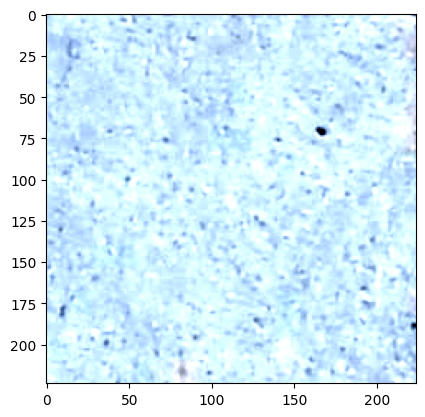

In [3]:
for i, d in enumerate(test_dataloader):
    print(f"{d[0].numpy().shape}, {d[1].numpy().shape}, {d[1][0]}={test_dataset.classes[d[1][0]]}")
    plt.imshow(d[0][0].permute(1, 2, 0))
    break

In [4]:
f = h5py.File('../resources/test_preprocessed_reduced.h5', 'w')
for i, data in enumerate(test_dataloader):
  new_data = data[0].numpy()
  new_label = np.expand_dims(data[1].numpy(), axis=1)
  
  if i == 0:
    # Create the dataset at first
    f.create_dataset('data', data=new_data, compression="gzip", chunks=True, maxshape=(None,3,224,224))
    f.create_dataset('label', data=new_label, compression="gzip", chunks=True, maxshape=(None,1)) 
  else:
    # Append new data to it
    f['data'].resize((f['data'].shape[0] + new_data.shape[0]), axis=0)
    f['data'][-new_data.shape[0]:] = new_data

    f['label'].resize((f['label'].shape[0] + new_label.shape[0]), axis=0)
    f['label'][-new_label.shape[0]:] = new_label

  print("I am on iteration {} and 'data' chunk has shape:{}".format(i,f['data'].shape))
  
  if i == 31: 
    break

f.close()

I am on iteration 0 and 'data' chunk has shape:(32, 3, 224, 224)
I am on iteration 1 and 'data' chunk has shape:(64, 3, 224, 224)
I am on iteration 2 and 'data' chunk has shape:(96, 3, 224, 224)
I am on iteration 3 and 'data' chunk has shape:(128, 3, 224, 224)
I am on iteration 4 and 'data' chunk has shape:(160, 3, 224, 224)
I am on iteration 5 and 'data' chunk has shape:(192, 3, 224, 224)
I am on iteration 6 and 'data' chunk has shape:(224, 3, 224, 224)
I am on iteration 7 and 'data' chunk has shape:(256, 3, 224, 224)
I am on iteration 8 and 'data' chunk has shape:(288, 3, 224, 224)
I am on iteration 9 and 'data' chunk has shape:(320, 3, 224, 224)
I am on iteration 10 and 'data' chunk has shape:(352, 3, 224, 224)
I am on iteration 11 and 'data' chunk has shape:(384, 3, 224, 224)
I am on iteration 12 and 'data' chunk has shape:(416, 3, 224, 224)
I am on iteration 13 and 'data' chunk has shape:(448, 3, 224, 224)
I am on iteration 14 and 'data' chunk has shape:(480, 3, 224, 224)
I am on 